<a href="https://colab.research.google.com/github/aomidvar/alibabainpersia/blob/master/Hybrid_LSTM_GRU_Financial_Forecasting_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Flatten, SimpleRNN, Conv1D, MaxPooling1D, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from google.colab import files

# DATA PREPARATION

In [ ]:
from google.colab import files
uploaded = files.upload() #choose your files.for example upload train_1,test_1
# Filter for the desired ticker.
df = pd.read_csv(io.BytesIO(uploaded['vatosa.csv']))

Saving vatosa.csv to vatosa.csv


In [ ]:
# Convert 'Date' column to datetime objects and set as index
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df.set_index('Date', inplace=True)

# Sort by date to ensure correct time series order
df.sort_index(inplace=True)

print("--- Data Head (filtered for VATOSAM_Share) ---")
print(df.head())
print("\n--- Data Info (filtered for VATOSAM_Share) ---")
df.info()

# We will focus on the 'Close' price for forecasting
close_prices = df['Close'].values.reshape(-1, 1)

--- Data Head (filtered for VATOSAM_Share) ---
                  Ticker  TIME    Open    High     Low   Close     Vol  \
Date                                                                     
2005-06-01  VATOSA_Share     0  160.26  167.14  160.26  164.39  583665   
2005-06-06  VATOSA_Share     0  164.10  166.95  162.23  164.19  286576   
2005-06-07  VATOSA_Share     0  162.23  163.60  160.06  162.03  376596   
2005-06-08  VATOSA_Share     0  160.36  165.18  160.26  161.83  480257   
2005-06-11  VATOSA_Share     0  161.83  164.29  161.83  162.52  357733   

            Openint  
Date                 
2005-06-01     1672  
2005-06-06     1670  
2005-06-07     1648  
2005-06-08     1646  
2005-06-11     1653  

--- Data Info (filtered for VATOSAM_Share) ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3289 entries, 2005-06-01 to 2020-05-31
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ticker   3289 non-null   ob

# DATA NORMALIZATION (Z-Score)


In [ ]:
scaler = StandardScaler()
scaled_prices = scaler.fit_transform(close_prices)

# CREATE TIME SERIES SEQUENCES

In [ ]:
def create_sequences(data, time_steps=60):
    """Creates input sequences and corresponding outputs for a time series model."""
    X, y = [], []
    for i in range(len(data) - time_steps):
        # The sequence of 'time_steps' length will be our input
        X.append(data[i:(i + time_steps), 0])
        # The value at the next step will be our output
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

TIME_STEPS = 60  # Use the last 60 days to predict the next day

# IMPORTANT: Ensure your dataset is large enough for the chosen TIME_STEPS.
# If your dataset has less than (TIME_STEPS + 1) rows, this will cause an error.
if len(scaled_prices) <= TIME_STEPS:
    print(f"Error: Not enough data points ({len(scaled_prices)}) to create sequences with TIME_STEPS={TIME_STEPS}.")
    print("Please provide a larger dataset (at least {TIME_STEPS + 1} data points) or reduce the TIME_STEPS value.")
    exit()

X, y = create_sequences(scaled_prices, TIME_STEPS)

# Reshape X to be [samples, time_steps, features] which is required for LSTM/GRU
X = X.reshape(X.shape[0], X.shape[1], 1)

# TRAIN-TEST SPLIT (80/20)

In [ ]:
# It's crucial to split time series data chronologically
train_size = int(len(X) * 0.8)

# Ensure valid train/test split
if train_size == 0 or train_size == len(X) or len(X) < 2:
    print("Error: Train/test split resulted in an empty training or test set, or insufficient total samples after sequence creation.")
    print("Consider adjusting TIME_STEPS or providing more data to ensure a meaningful split.")
    exit()

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"\n--- Data Shapes ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Proceed with model training and evaluation only if test data exists
if X_test.shape[0] == 0:
    print("\nWarning: X_test is empty. Skipping model training and evaluation due to insufficient test data.")
else:
    # Clear any previous TensorFlow/Keras session state to prevent "AlreadyExistsError"
    tf.keras.backend.clear_session()


--- Data Shapes ---
X_train shape: (2583, 60, 1)
y_train shape: (2583,)
X_test shape: (646, 60, 1)
y_test shape: (646,)


# BUILD THE HYBRID LSTM-GRU MODEL

In [ ]:
model = Sequential()

# Layer 1: LSTM layer with 124 hidden units.
# `return_sequences=True` is necessary to pass the output sequence to the next GRU layer.
model.add(LSTM(units=124, return_sequences=True, input_shape=(TIME_STEPS, 1)))
model.add(Dropout(0.2)) # Add dropout for regularization

# Layer 2: GRU layer.
# The output of the LSTM layer is the input to this layer.
# `return_sequences=False` as this is the last recurrent layer.
model.add(GRU(units=64, return_sequences=False))
model.add(Dropout(0.2))

# Layer 3: Output layer.
# A Dense layer with 1 unit for the final regression output.
model.add(Dense(units=1))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# COMPILE THE MODEL

In [ ]:

    # Use the Adam optimizer and Mean Squared Error for loss.
    # We include R^2 score as an evaluation metric, accessed via tf.keras.metrics.R2Score.
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[tf.keras.metrics.R2Score()])

    # Print the model summary
    print("\n--- Model Summary ---")
    model.summary()


--- Model Summary ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 60, 124)        │        62,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 124)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        36,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,041 (386.88 KB)

 Trainable params: 99,041 (386.88 KB)

 Non-trainable params: 0 (0.00 B)

# TRAIN THE MODEL

In [ ]:
    print("\n--- Starting Model Training ---")
    # This 'history' line needs to be at the same indentation level as 'model = Sequential()'
    # and 'model.compile()', which is 4 spaces inside the 'else' block.
    history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.1, # Use 10% of training data for validation
        verbose=1
    )
    print("--- Model Training Finished ---")


--- Starting Model Training ---
Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0310 - r2_score: -0.7596 - val_loss: 9.2413e-04 - val_r2_score: 0.6374
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - r2_score: 0.9242 - val_loss: 6.1207e-04 - val_r2_score: 0.7599
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010 - r2_score: 0.9386 - val_loss: 5.9960e-04 - val_r2_score: 0.7648
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.0230e-04 - r2_score: 0.9464 - val_loss: 5.4201e-04 - val_r2_score: 0.7873
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.2425e-04 - r2_score: 0.9527 - val_loss: 5.1000e-04 - val_r2_score: 0.7999
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.2304e-04 - r2_score: 0.9469 - val_loss: 6.9961e-04 - val_r2_score: 0.7255
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.6552e-04 - r2_score: 0.9514 - val_loss: 6.2206e-04 - val_r2_score: 0.7559
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━

# EVALUATE THE MODEL

In [ ]:
    # This line MUST have the same indentation as 'history = model.fit(...)'
    # and other lines within this 'else' block.
    predicted_prices_scaled = model.predict(X_test)

    # Inverse transform the predictions and the actual values to get the original price scale
    predicted_prices = scaler.inverse_transform(predicted_prices_scaled)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test_actual, predicted_prices)
    r2 = r2_score(y_test_actual, predicted_prices)

    print("\n--- Model Evaluation on Test Data ---")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R-squared (R²): {r2:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

--- Model Evaluation on Test Data ---
Mean Squared Error (MSE): 635600.26
R-squared (R²): 0.9108


# VISUALIZE THE RESULTS

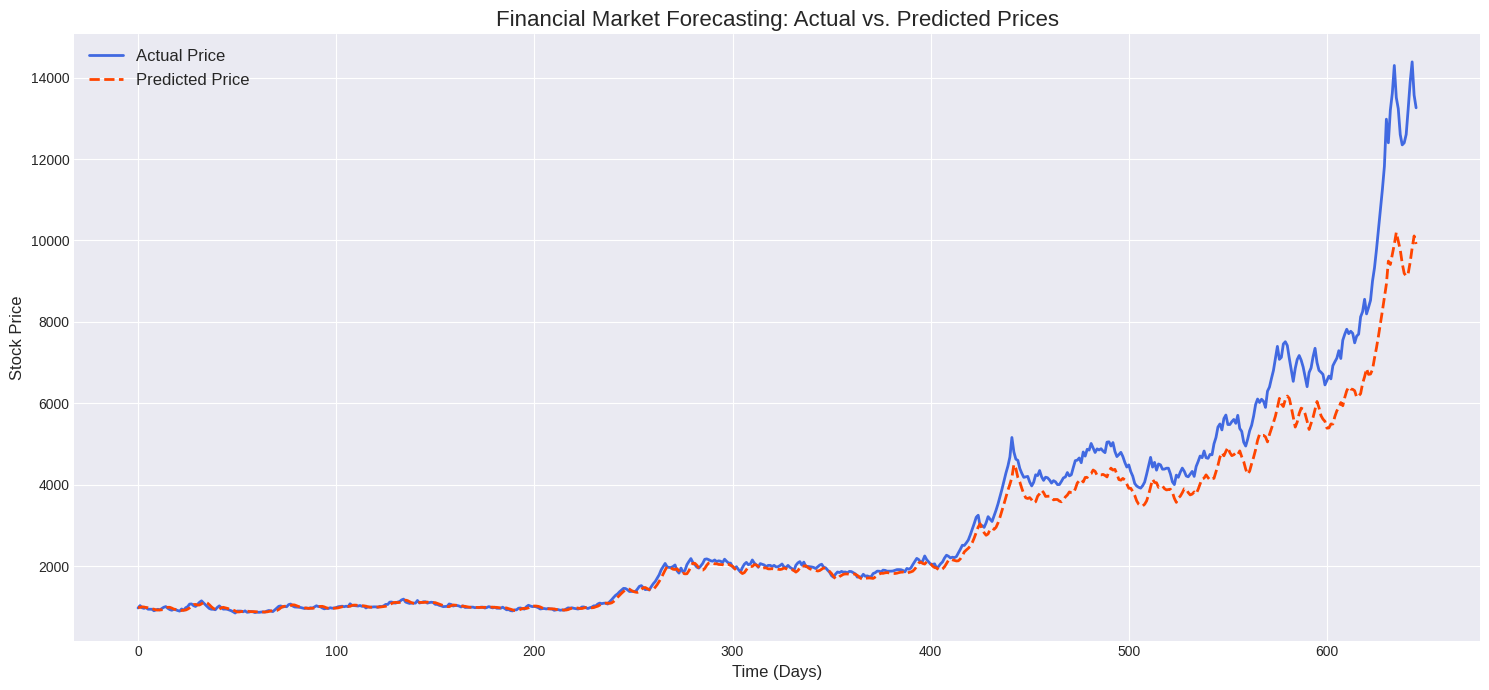

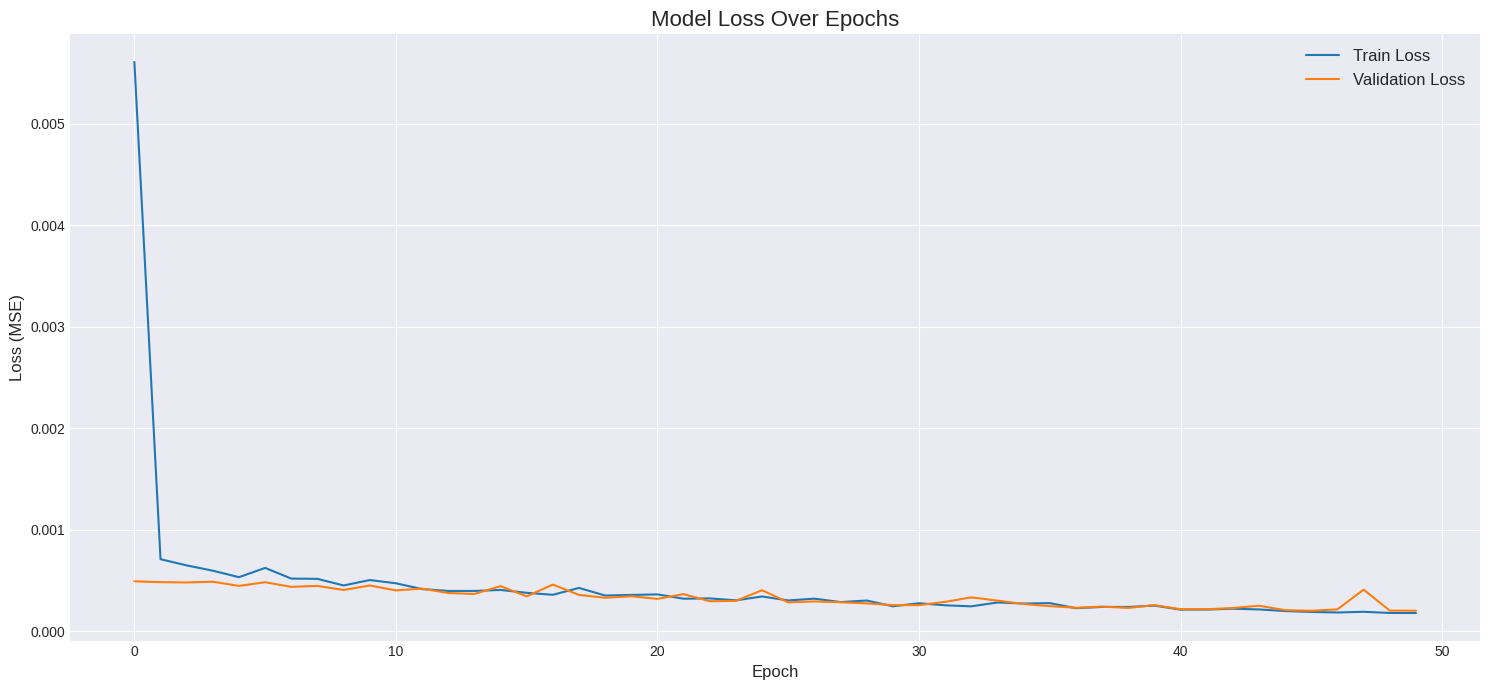

In [ ]:
    plt.style.use('seaborn-v0_8-darkgrid')

    # Plot actual vs. predicted prices
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.plot(y_test_actual, color='royalblue', label='Actual Price', linewidth=2)
    ax.plot(predicted_prices, color='orangered', label='Predicted Price', linestyle='--', linewidth=2)
    ax.set_title('Financial Market Forecasting: Actual vs. Predicted Prices', fontsize=16)
    ax.set_xlabel('Time (Days)', fontsize=12)
    ax.set_ylabel('Stock Price', fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(True)
    plt.tight_layout()
    plt.show() # Use plt.show() when running locally

    # Plot training & validation loss values
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.plot(history.history['loss'], label='Train Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_title('Model Loss Over Epochs', fontsize=16)
    ax.set_ylabel('Loss (MSE)', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.legend(loc='upper right', fontsize=12)
    ax.grid(True)
    plt.tight_layout()
    plt.show() # Use plt.show() when running locally

# comparison

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
# Import Flatten layer
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam


# --- Fix: Reshape y_train and y_test to be 2D for Keras compatibility ---
# We will explicitly flatten them back to 1D for scikit-learn models inside train_and_evaluate
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
# --- End Fix ---

print(f"\n--- Data Shapes ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

if X_test.shape[0] == 0:
    print("\nWarning: X_test is empty. Skipping model training and evaluation due to insufficient test data.")
    exit()

# --- Model Building Functions ---

def build_hybrid_lstm_gru_model(time_steps):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(units=124, return_sequences=True, input_shape=(time_steps, 1)))
    model.add(Dropout(0.2))
    model.add(GRU(units=64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    return model

def build_lstm_model(time_steps):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(units=124, return_sequences=False, input_shape=(time_steps, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    return model

def build_gru_model(time_steps):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(GRU(units=124, return_sequences=False, input_shape=(time_steps, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    return model

def build_dense_model(time_steps):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Flatten(input_shape=(time_steps, 1)))
    model.add(Dense(units=124, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    return model
  # CNN Model
def build_cnn_model(time_steps):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

# Simple RNN Model
def build_simple_rnn_model(time_steps):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(SimpleRNN(units=64, return_sequences=False, input_shape=(time_steps, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    return model

# Transformer Model (functional API)
def build_transformer_model(time_steps, d_model=64, num_heads=4, ff_dim=128):
    tf.keras.backend.clear_session()
    inputs = Input(shape=(time_steps, 1))

    # Project input to d_model dimensions
    x = Dense(d_model)(inputs)

    # Positional encoding is skipped for simplicity
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attention = Dropout(0.1)(attention)
    x = LayerNormalization(epsilon=1e-6)(x + attention)

    # Feed-forward layer
    ffn = Dense(ff_dim, activation='relu')(x)
    ffn = Dense(d_model)(ffn)
    ffn = Dropout(0.1)(ffn)
    x = LayerNormalization(epsilon=1e-6)(x + ffn)

    # Global average pooling and output
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model



# --- Helper function for training and evaluation (now handles Keras and Sklearn) ---

def train_and_evaluate(model, X_train_data, y_train_data, X_test_data, y_test_data, scaler_obj, model_name):
    print(f"\n--- Building and Training {model_name} ---")

    history = None

    if isinstance(model, tf.keras.Model):
        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[tf.keras.metrics.R2Score()])
        print(f"\nModel Summary for {model_name}:")
        model.summary()

        history = model.fit(
            X_train_data,
            y_train_data, # y_train_data is already (samples, 1) for Keras
            epochs=50,
            batch_size=32,
            validation_split=0.1,
            verbose=0
        )
        predicted_scaled = model.predict(X_test_data)

    else: # Scikit-learn model (e.g., DecisionTreeRegressor)
        # Flatten the input X data for scikit-learn models (which expect 2D: samples, features)
        X_train_data_flat = X_train_data.reshape(X_train_data.shape[0], -1)
        X_test_data_flat = X_test_data.reshape(X_test_data.shape[0], -1)

        # --- FIX: Flatten y data for scikit-learn models ---
        y_train_data_flat = y_train_data.flatten()
        y_test_data_flat = y_test_data.flatten()
        # --- END FIX ---

        model.fit(X_train_data_flat, y_train_data_flat) # Use flattened y for scikit-learn
        predicted_scaled = model.predict(X_test_data_flat).reshape(-1, 1) # Ensure predictions are 2D for inverse_transform

    print(f"--- {model_name} Training Finished ---")

    predicted_actual = scaler_obj.inverse_transform(predicted_scaled)
    # y_test_data is already (samples, 1) for original comparison against Keras models' output
    y_test_actual = scaler_obj.inverse_transform(y_test_data)

    mse = mean_squared_error(y_test_actual, predicted_actual)
    r2 = r2_score(y_test_actual, predicted_actual)

    print(f"--- {model_name} Evaluation on Test Data ---")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R-squared (R²): {r2:.4f}")

    return {
        'model_name': model_name,
        'predicted_prices': predicted_actual,
        'mse': mse,
        'r2': r2,
        'history': history
    }



--- Data Shapes ---
X_train shape: (2583, 60, 1)
y_train shape: (2583, 1)
X_test shape: (646, 60, 1)
y_test shape: (646, 1)


In [ ]:

# --- Train and Evaluate All Models ---

models_to_compare = []

# Recurrent Models (expect 3D input)
models_to_compare.append(train_and_evaluate(
    build_hybrid_lstm_gru_model(TIME_STEPS), X_train, y_train, X_test, y_test, scaler, "Hybrid LSTM-GRU"
))

models_to_compare.append(train_and_evaluate(
    build_lstm_model(TIME_STEPS), X_train, y_train, X_test, y_test, scaler, "Simple LSTM"
))

models_to_compare.append(train_and_evaluate(
    build_gru_model(TIME_STEPS), X_train, y_train, X_test, y_test, scaler, "Simple GRU"
))

# Non-Recurrent Models (Dense and Decision Tree)
models_to_compare.append(train_and_evaluate(
    build_dense_model(TIME_STEPS), X_train, y_train, X_test, y_test, scaler, "Dense (MLP)"
))
# CNN
models_to_compare.append(train_and_evaluate(
    build_cnn_model(TIME_STEPS), X_train, y_train, X_test, y_test, scaler, "1D CNN"
))

# Simple RNN
models_to_compare.append(train_and_evaluate(
    build_simple_rnn_model(TIME_STEPS), X_train, y_train, X_test, y_test, scaler, "Simple RNN"
))

# Transformer
models_to_compare.append(train_and_evaluate(
    build_transformer_model(TIME_STEPS), X_train, y_train, X_test, y_test, scaler, "Transformer"
))




--- Building and Training Hybrid LSTM-GRU ---

Model Summary for Hybrid LSTM-GRU:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 124)        │        62,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 124)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        36,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,041 (386.88 KB)

 Trainable params: 99,041 (386.88 KB)

 Non-trainable params: 0 (0.00 B)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
--- Hybrid LSTM-GRU Training Finished ---
--- Hybrid LSTM-GRU Evaluation on Test Data ---
Mean Squared Error (MSE): 858351.97
R-squared (R²): 0.8796

--- Building and Training Simple LSTM ---

Model Summary for Simple LSTM:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 124)            │        62,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 124)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,621 (244.61 KB)

 Trainable params: 62,621 (244.61 KB)

 Non-trainable params: 0 (0.00 B)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
--- Simple LSTM Training Finished ---
--- Simple LSTM Evaluation on Test Data ---
Mean Squared Error (MSE): 1120976.60
R-squared (R²): 0.8427

--- Building and Training Simple GRU ---

Model Summary for Simple GRU:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 124)            │        47,244 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 124)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,369 (185.04 KB)

 Trainable params: 47,369 (185.04 KB)

 Non-trainable params: 0 (0.00 B)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
--- Simple GRU Training Finished ---
--- Simple GRU Evaluation on Test Data ---
Mean Squared Error (MSE): 1021610.13
R-squared (R²): 0.8566

--- Building and Training Dense (MLP) ---

Model Summary for Dense (MLP):


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 124)            │         7,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 124)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,689 (30.04 KB)

 Trainable params: 7,689 (30.04 KB)

 Non-trainable params: 0 (0.00 B)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
--- Dense (MLP) Training Finished ---
--- Dense (MLP) Evaluation on Test Data ---
Mean Squared Error (MSE): 41489037.19
R-squared (R²): -4.8219

--- Building and Training 1D CNN ---

Model Summary for 1D CNN:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 58, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1856)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       118,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,169 (465.50 KB)

 Trainable params: 119,169 (465.50 KB)

 Non-trainable params: 0 (0.00 B)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
--- 1D CNN Training Finished ---
--- 1D CNN Evaluation on Test Data ---
Mean Squared Error (MSE): 71994.25
R-squared (R²): 0.9899

--- Building and Training Simple RNN ---

Model Summary for Simple RNN:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
--- Simple RNN Training Finished ---
--- Simple RNN Evaluation on Test Data ---
Mean Squared Error (MSE): 2100289.40
R-squared (R²): 0.7053

--- Building and Training Transformer ---

Model Summary for Transformer:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 60, 64)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 64)    │     66,368 │ dense[0][0],      │
│ (MultiHeadAttentio… │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 60, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 64)    │          0 │ dense[0][0],      │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 60, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 60, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 60, 64)    │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 60, 64)    │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 83,393 (325.75 KB)

 Trainable params: 83,393 (325.75 KB)

 Non-trainable params: 0 (0.00 B)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
--- Transformer Training Finished ---
--- Transformer Evaluation on Test Data ---
Mean Squared Error (MSE): 8871252.25
R-squared (R²): -0.2449


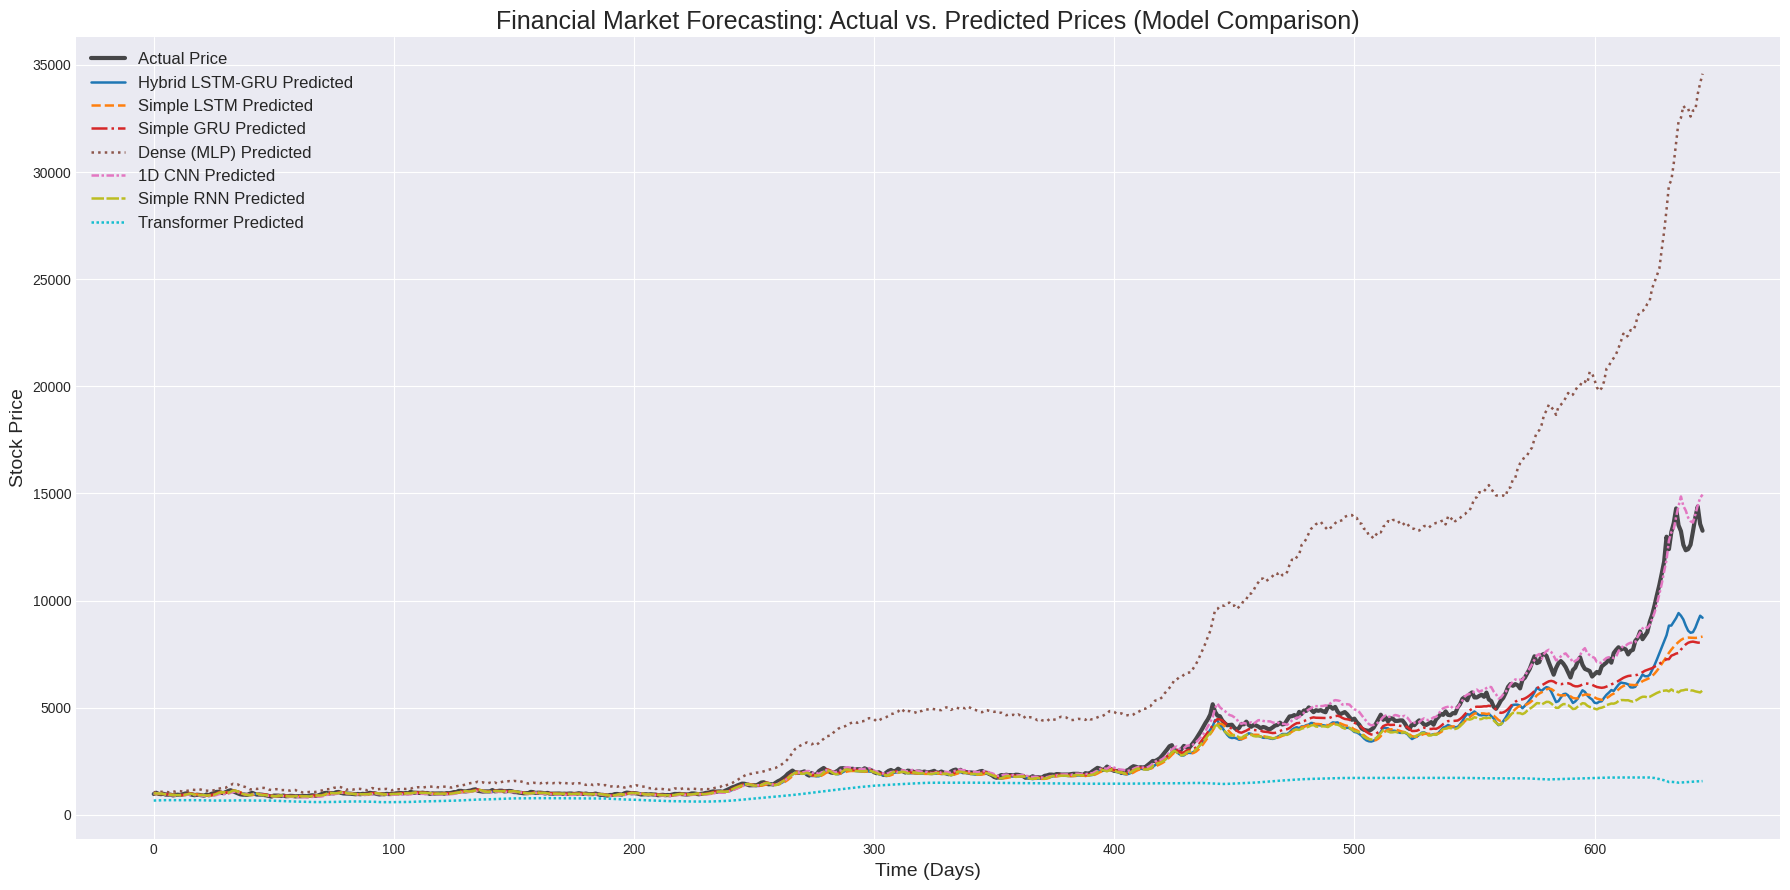

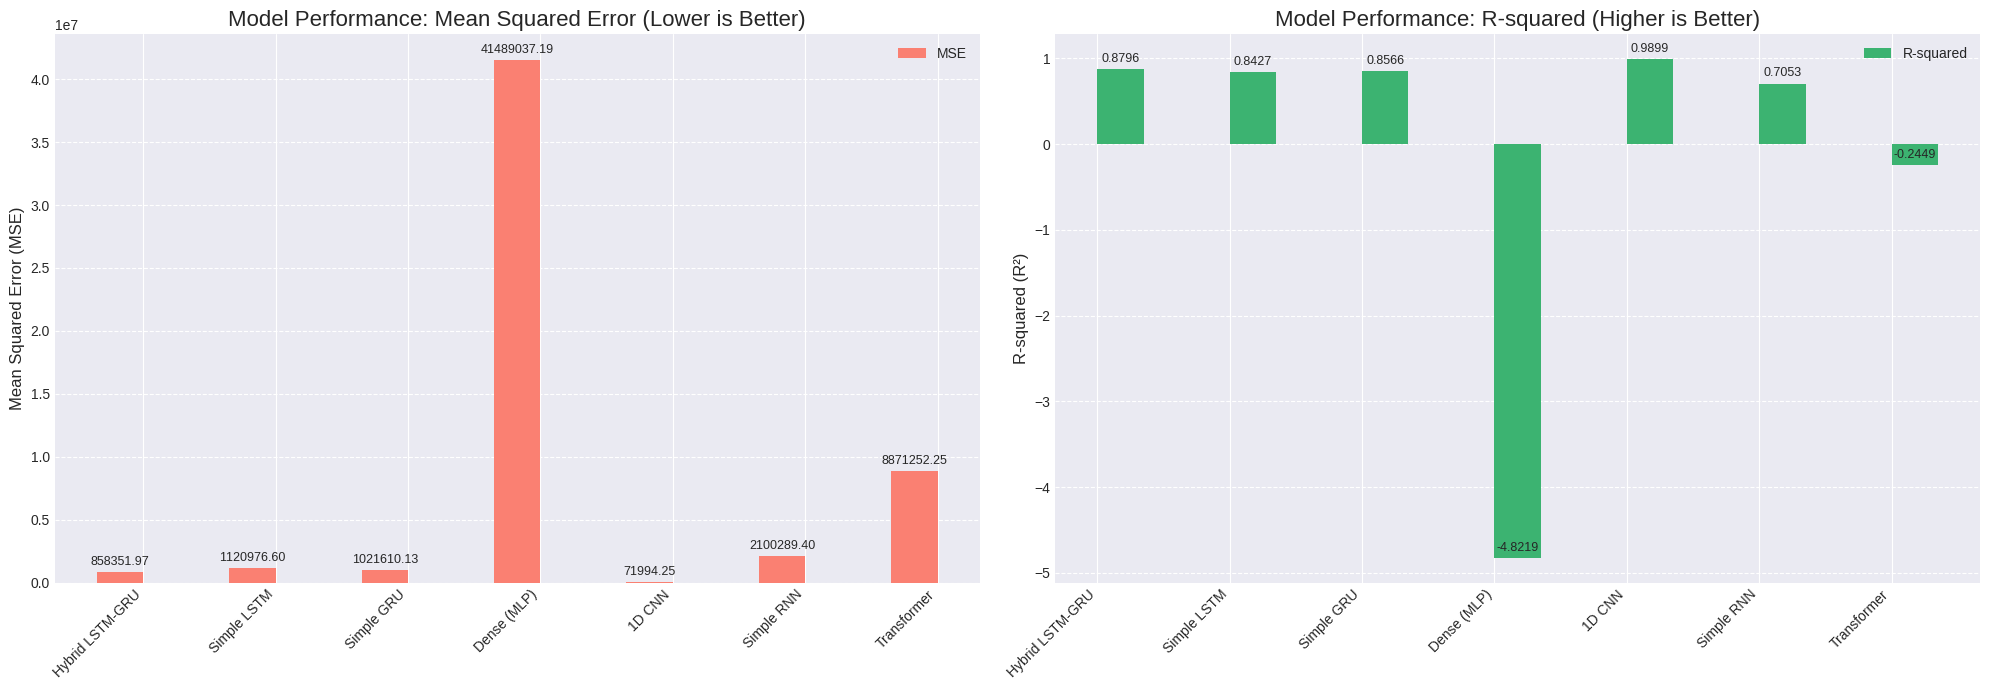

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Visualize Comparisons ---

plt.style.use('seaborn-v0_8-darkgrid')

# 1. Plot Actual vs. Predicted Prices for all models
fig, ax = plt.subplots(figsize=(18, 9))
y_test_actual_val = scaler.inverse_transform(y_test)

ax.plot(y_test_actual_val, color='black', label='Actual Price', linewidth=3, alpha=0.7)

# Automatically cycle through enough colors and linestyles
colors = plt.cm.tab10(np.linspace(0, 1, len(models_to_compare)))
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 1)), (0, (1, 1))]

for i, model_result in enumerate(models_to_compare):
    ax.plot(model_result['predicted_prices'],
            color=colors[i % len(colors)],
            linestyle=linestyles[i % len(linestyles)],
            label=f"{model_result['model_name']} Predicted",
            linewidth=1.8)

ax.set_title('Financial Market Forecasting: Actual vs. Predicted Prices (Model Comparison)', fontsize=18)
ax.set_xlabel('Time (Days)', fontsize=14)
ax.set_ylabel('Stock Price', fontsize=14)
ax.legend(fontsize=12, loc='upper left')
ax.grid(True)
plt.tight_layout()
plt.show()

# 2. Bar Chart for MSE and R-squared Comparison
model_names = [res['model_name'] for res in models_to_compare]
mse_scores = [res['mse'] for res in models_to_compare]
r2_scores = [res['r2'] for res in models_to_compare]

x = np.arange(len(model_names))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# MSE Bar Chart
rects1 = ax1.bar(x - width/2, mse_scores, width, label='MSE', color='salmon')
ax1.set_ylabel('Mean Squared Error (MSE)', fontsize=12)
ax1.set_title('Model Performance: Mean Squared Error (Lower is Better)', fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45, ha="right", fontsize=10)
ax1.legend()
ax1.grid(axis='y', linestyle='--')
for rect in rects1:
    height = rect.get_height()
    ax1.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

# R-squared Bar Chart
rects2 = ax2.bar(x + width/2, r2_scores, width, label='R-squared', color='mediumseagreen')
ax2.set_ylabel('R-squared (R²)', fontsize=12)
ax2.set_title('Model Performance: R-squared (Higher is Better)', fontsize=16)
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=45, ha="right", fontsize=10)
ax2.legend()
ax2.grid(axis='y', linestyle='--')
for rect in rects2:
    height = rect.get_height()
    ax2.annotate(f'{height:.4f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


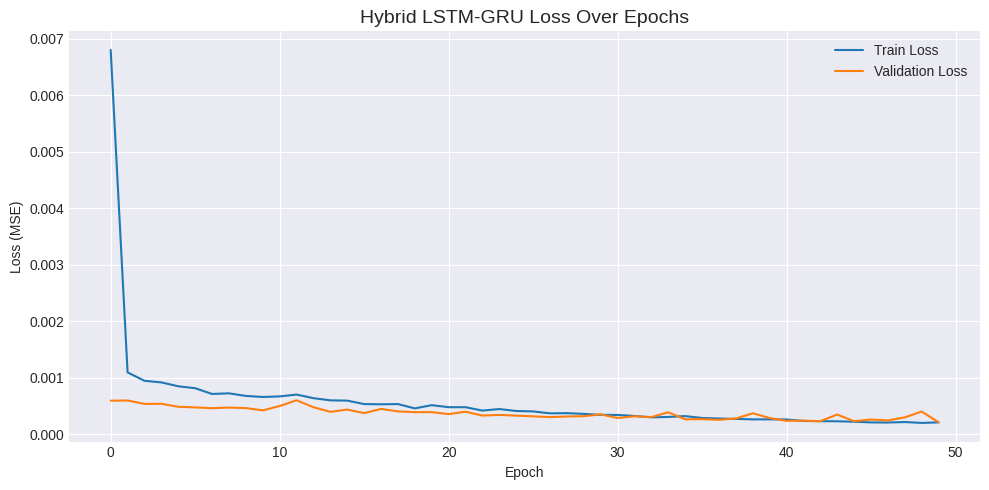

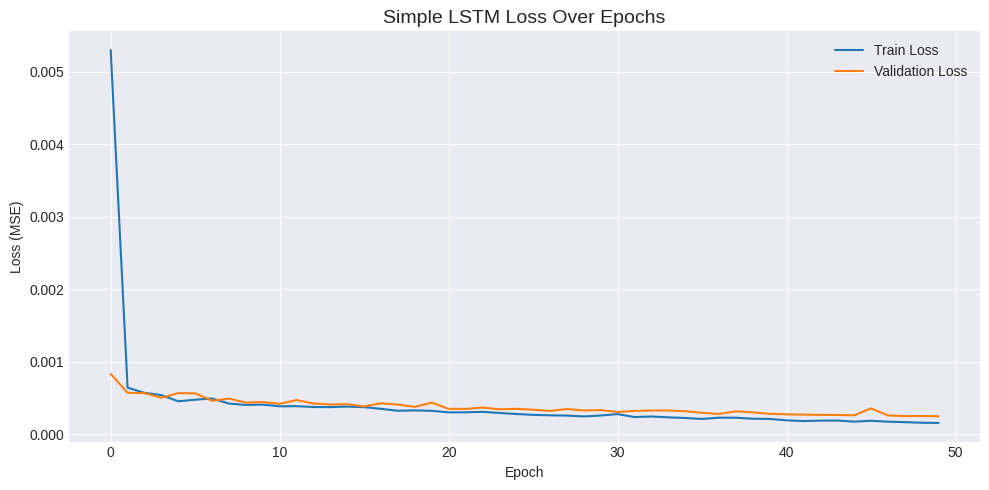

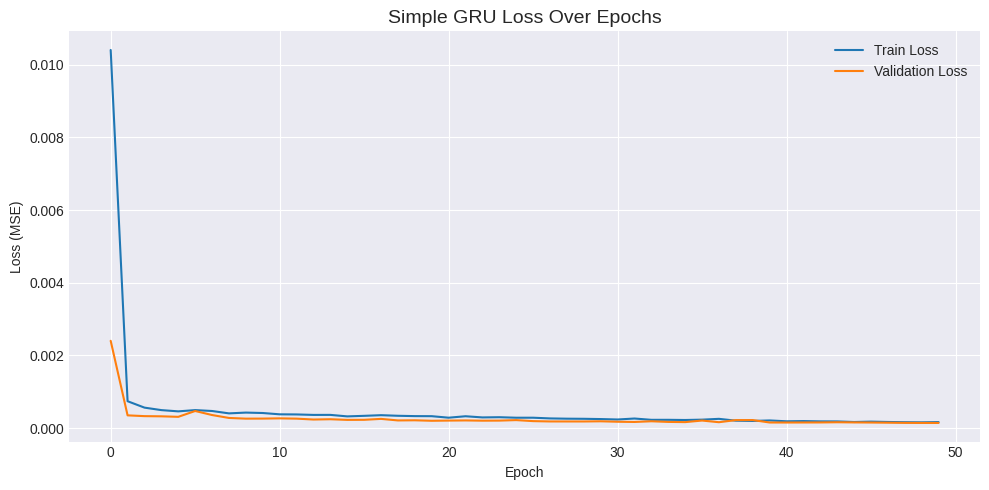

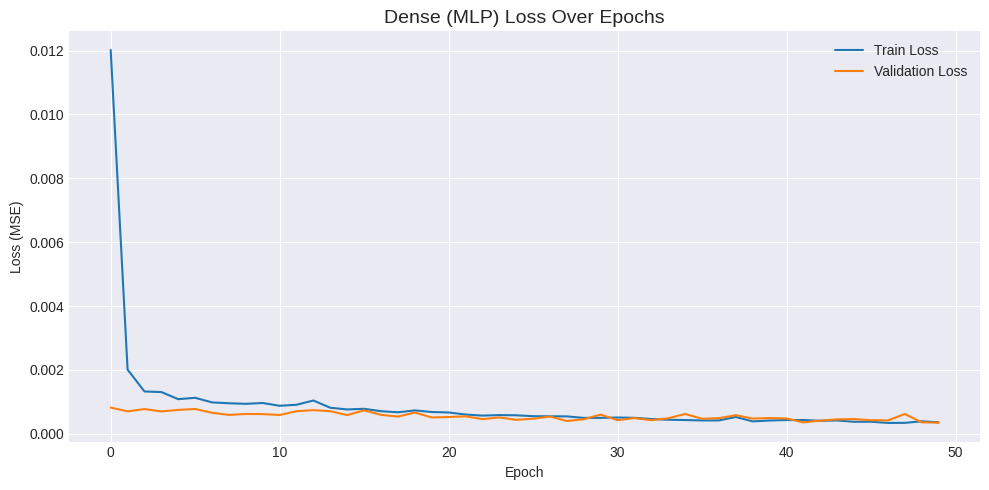

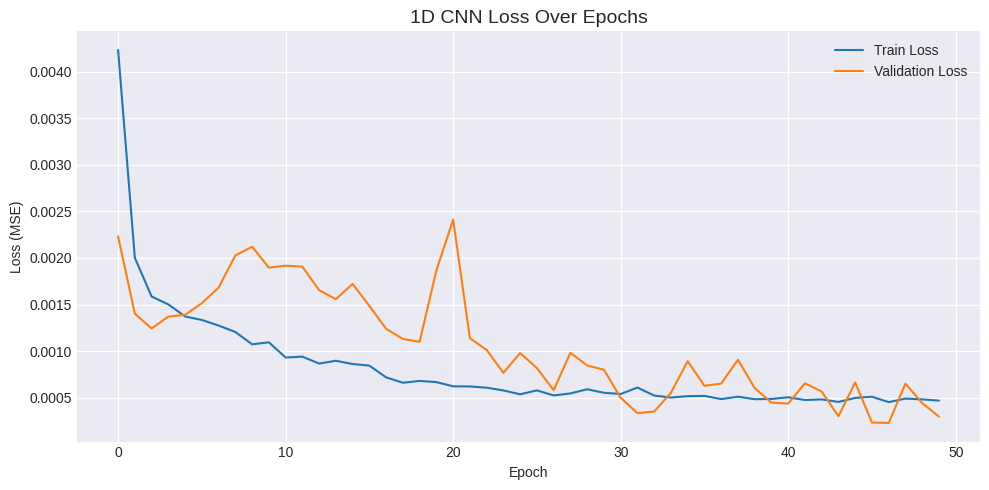

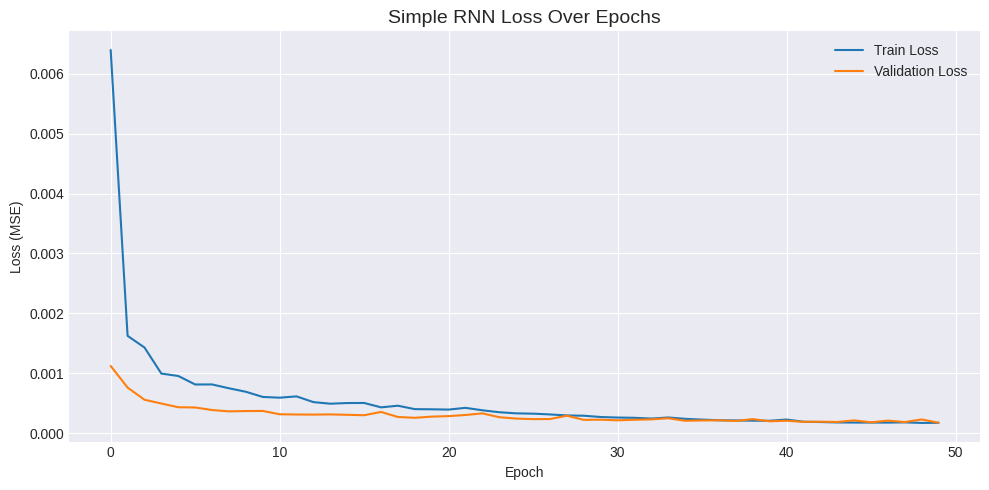

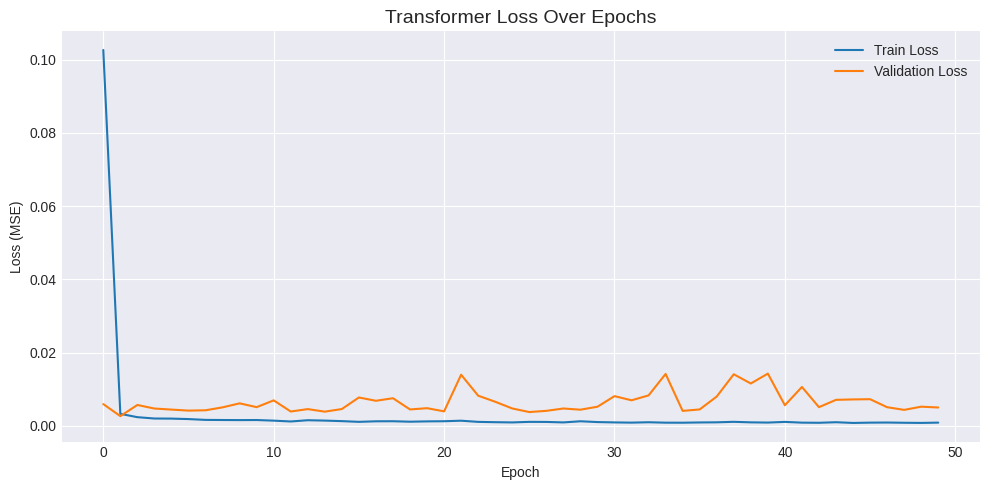

In [ ]:

# Optional: Plot training & validation loss for Keras models
for model_result in models_to_compare:
     if model_result['history'] is not None:
         fig, ax = plt.subplots(figsize=(10, 5))
         ax.plot(model_result['history'].history['loss'], label='Train Loss')
         ax.plot(model_result['history'].history['val_loss'], label='Validation Loss')
         ax.set_title(f"{model_result['model_name']} Loss Over Epochs", fontsize=14)
         ax.set_ylabel('Loss (MSE)', fontsize=10)
         ax.set_xlabel('Epoch', fontsize=10)
         ax.legend(loc='upper right', fontsize=10)
         ax.grid(True)
         plt.tight_layout()
         plt.show()